## Beta testing notebook for testing the basic functionality of our transformer model
### Matt Sampson 2024

In [9]:
# first lets import the required packages
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random

main_rng = random.PRNGKey(42)

# import components of the model
from model import (
    PositionalEncoding,
    scaled_dot_product,
    MultiheadAttention,
    EncoderBlock,
    TransformerEncoder,
    cosine_warmup_schedule,
)

# consitent plotting style for notebook/paper
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update({"text.usetex": True})

In [10]:
seq_len, d_k = 3, 2
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 [[-0.6613315   0.70056266]
 [ 0.08239268 -1.7793142 ]
 [-0.04378588  1.0965251 ]]
K
 [[ 1.7257481   0.35568172]
 [ 1.3034704   1.2873708 ]
 [ 1.6871481  -0.5714404 ]]
V
 [[ 1.5129997   1.1050899 ]
 [ 0.27949408 -0.46224892]
 [-1.1003422  -1.1437944 ]]
Values
 [[ 0.376226   -0.1465618 ]
 [-0.42778552 -0.5989566 ]
 [ 0.43624765 -0.116783  ]]
Attention
 [[0.27963293 0.54049295 0.17987415]
 [0.22194657 0.06706189 0.71099156]
 [0.27977088 0.5837308  0.13649833]]


In [11]:
## Test MultiheadAttention implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embed_dim=128, num_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)["params"]
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({"params": params}, x)
print("Out", out.shape, "Attention", attn.shape)

del mh_attn, params

Out (3, 16, 128) Attention (3, 4, 16, 16)


In [12]:
## Test EncoderBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = EncoderBlock(
    input_dim=128, num_heads=4, dim_feedforward=512, dropout_prob=0.1
)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init(
    {"params": init_rng, "dropout": dropout_init_rng}, x, train=True
)["params"]
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply(
    {"params": params}, x, train=True, rngs={"dropout": dropout_apply_rng}
)
print("Out", out.shape)

del encblock, params

Out (3, 16, 128)


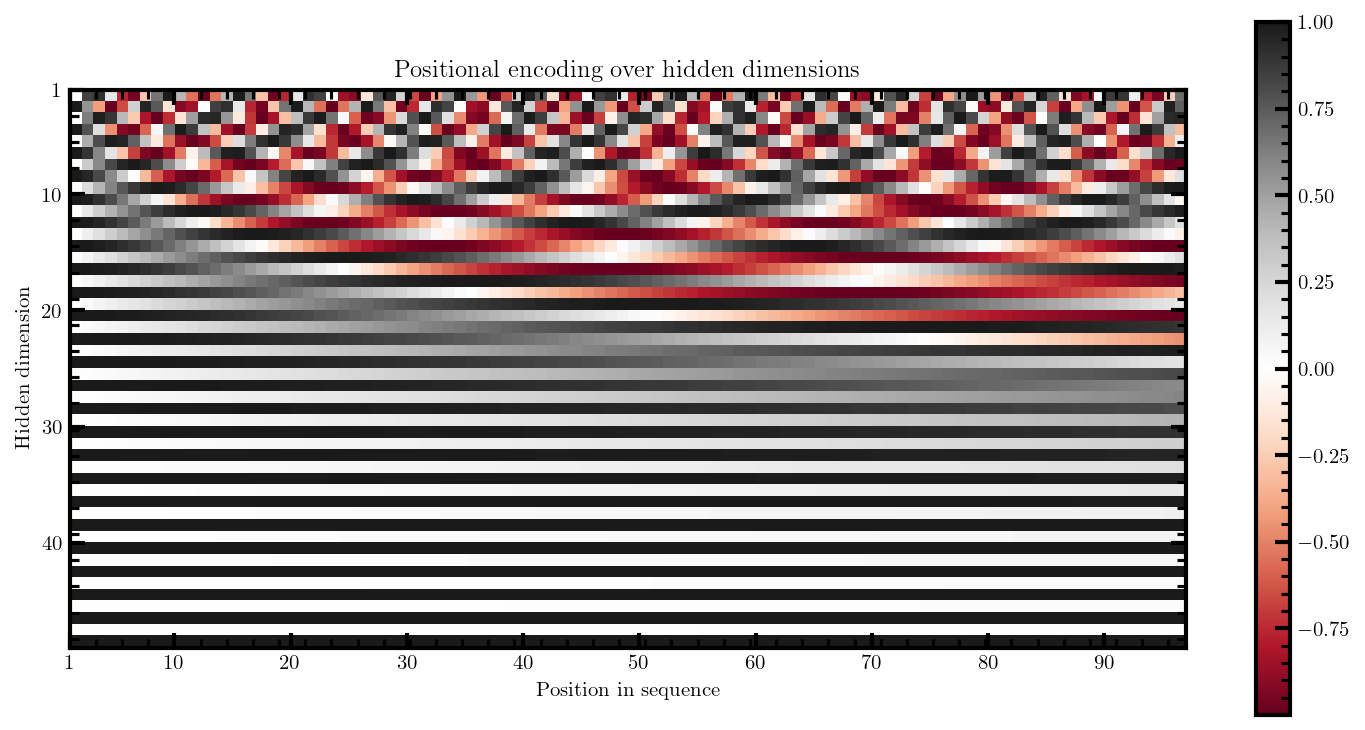

In [13]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(d_model=48, max_len=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.pe.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=150)
pos = ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

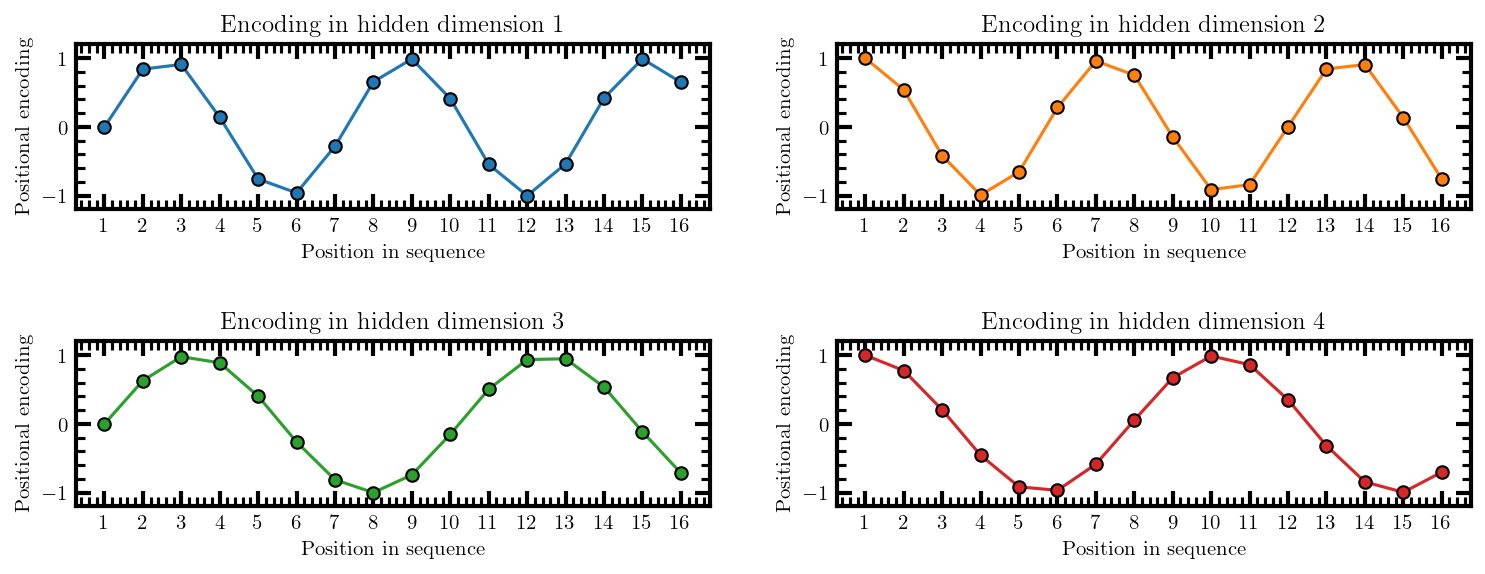

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=150)
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(
        np.arange(1, 17),
        pe[i, :16],
        color=f"C{i}",
        marker="o",
        markersize=6,
        markeredgecolor="black",
    )
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1, 17))
    ax[i].tick_params(axis="both", which="major", labelsize=10)
    ax[i].tick_params(axis="both", which="minor", labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
plt.show()

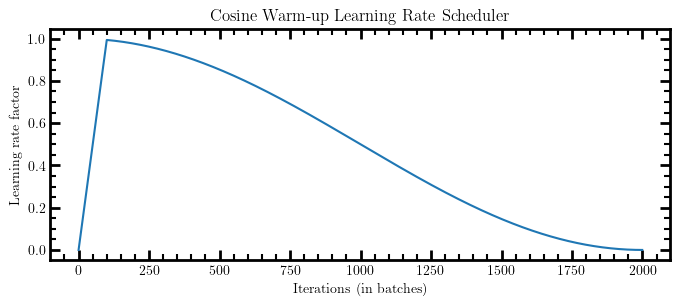

In [15]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()

In [16]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(
    num_layers=5, input_dim=128, num_heads=4, dim_feedforward=256, dropout_prob=0.15
)
# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init(
    {"params": init_rng, "dropout": dropout_init_rng}, x, train=True
)["params"]
# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({"params": params}, rngs={"dropout": dropout_apply_rng})
out = binded_mod(x, train=True)
print("Out", out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print("Attention maps", len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)
